In [1]:
import torch
import scipy
import numpy as np
import os
import math
import time
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from torchsummary import summary
from PIL import Image
import util
from pytorch_msssim import ssim
import random

In [2]:
#----------------------------------------------------------------------
# the network

class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=24):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.encoder2 = UNet._block(features, features, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.encoder3 = UNet._block(features, features, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.encoder4 = UNet._block(features, features, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.bottleneck = UNet._block(features, features, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features, features, kernel_size=2, stride=1
        )
        self.decoder4 = UNet._block(features*2, features, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features, features, kernel_size=2, stride=1
        )
        self.decoder3 = UNet._block(features*2, features, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features, features, kernel_size=2, stride=1
        )
        self.decoder2 = UNet._block(features*2, features, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features, features, kernel_size=2, stride=1
        )
        self.decoder1 = UNet._block(features*2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.clamp(self.conv(dec1), -0.5, 0.5)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [3]:
#----------------------------------------------------------------------------
# Dataset noising functions

def fftshift2d(x, ifft=False):
    assert (len(x.shape) == 2) and all([(s % 2 == 1) for s in x.shape])
    s0 = (x.shape[0] // 2) + (0 if ifft else 1)
    s1 = (x.shape[1] // 2) + (0 if ifft else 1)
    x = np.concatenate([x[s0:, :], x[:s0, :]], axis=0)
    x = np.concatenate([x[:, s1:], x[:, :s1]], axis=1)
    return x

augment_translate_cache = dict()
def augment_data(img, spec, params):
    t = params.get('translate', 0)
    if t > 0:
        global augment_translate_cache
        trans = np.random.randint(-t, t + 1, size=(2,))
        key = (trans[0], trans[1])
        if key not in augment_translate_cache:
            x = np.zeros_like(img)
            x[trans[0], trans[1]] = 1.0
            augment_translate_cache[key] = fftshift2d(np.fft.fft2(x).astype(np.complex64))
        img = np.roll(img, trans, axis=(0, 1))
        spec = spec * augment_translate_cache[key]
    return img, spec

bernoulli_mask_cache = dict()
def corrupt_data(img, spec, params):
    ctype = params['type']
    assert ctype == 'bspec'
    p_at_edge = params['p_at_edge']
    global bernoulli_mask_cache
    if bernoulli_mask_cache.get(p_at_edge) is None:
        h = [s // 2 for s in spec.shape]
        r = [np.arange(s, dtype=np.float32) - h for s, h in zip(spec.shape, h)]
        r = [x ** 2 for x in r]
        r = (r[0][:, np.newaxis] + r[1][np.newaxis, :]) ** .5
        m = (p_at_edge ** (1./h[1])) ** r
        bernoulli_mask_cache[p_at_edge] = m
        print('Bernoulli probability at edge = %.5f' % m[h[0], 0])
        print('Average Bernoulli probability = %.5f' % np.mean(m))
    mask = bernoulli_mask_cache[p_at_edge]
    keep = (np.random.uniform(0.0, 1.0, size=spec.shape)**2 < mask)
    keep = keep & keep[::-1, ::-1]
    sval = spec * keep
    smsk = keep.astype(np.float32)
    spec = fftshift2d(sval / (mask + ~keep), ifft=True) # Add 1.0 to not-kept values to prevent div-by-zero.
    img = np.real(np.fft.ifft2(spec)).astype(np.float32)[:,:-1]
    return img, sval, smsk

def corrupt_data_gaussian(img, spec, params):
    rows = spec.shape[0]
    central_band = params['central_band']
    corrupt_fraction_central = params['corrupt_fraction_central']
    corrupt_fraction_side = params['corrupt_fraction_side']
    variance = params['variance']
    low_band_idx = int(rows*(1-central_band)/2)
    hi_band_idx = int(rows*(1+central_band)/2)
    ## lower band
    corrupt_rows = random.sample(range(0, low_band_idx), int(low_band_idx*corrupt_fraction_side))
    ## central band
    corrupt_rows += random.sample(range(low_band_idx, hi_band_idx), int((hi_band_idx-low_band_idx)*corrupt_fraction_central))
    ## upper band
    corrupt_rows += random.sample(range(low_band_idx, rows), int((rows-hi_band_idx)*corrupt_fraction_side))
    
    noise = np.random.randn(*spec.shape) + np.random.randn(*spec.shape)*1j
    noise *= np.sqrt(variance/2)
    clean_rows = list(set(range(rows)) - set(corrupt_rows))
    noise[clean_rows,:] = 0
    corrupt_spec = spec + noise
    corrupt_spec = fftshift2d(corrupt_spec, ifft=True)
    corrupt_img = np.real(np.fft.ifft2(corrupt_spec)).astype(np.float32)[:,:-1]
    return corrupt_img, corrupt_spec

def rrmse(arrX, arrY):
    v = np.square(arrX - arrY).sum()
    v /= np.square(arrX - arrX.mean(axis=0)).sum()
    v = np.sqrt(v)
    return v

In [15]:
#----------------------------------------------------------------------------
# Dataset loader

def load_dataset(fn, num_images=None, shuffle=False):
    # datadir = submit.get_path_from_template(config_mri.data_dir)
    datadir = '../mri-pkl'
    if fn.lower().endswith('.pkl'):
        abspath = os.path.join(datadir, fn)
        print ('Loading dataset from', abspath)
        img, spec = util.load_pkl(abspath)
    else:
        assert False

    if shuffle:
        perm = np.arange(img.shape[0])
        np.random.shuffle(perm)
        if num_images is not None:
            perm = perm[:num_images]
        img = img[perm]
        spec = spec[perm]

    if num_images is not None:
        img = img[:num_images]
        spec = spec[:num_images]

    # Remove last row/column of the images, we're officially 255x255 now.
    img = img[:, :-1, :-1]

    # Convert to float32.
    assert img.dtype == np.uint8
    img = img.astype(np.float32) / 255.0 - 0.5

    return img, spec

dataset_train, dataset_test = dict(), dict()
train_img, train_spec = load_dataset('ixi_train.pkl')
test_img, test_spec = load_dataset('ixi_valid.pkl')

train_X, train_Y = np.zeros_like(train_img), np.zeros_like(train_img)
test_X, test_Y = np.zeros_like(test_img), np.zeros_like(test_img)

corrupt_params = {
    'type' : 'bspec',
    'p_at_edge' : 0.01
}
corrupt_params_gaussian = {
    'central_band' : 1/4,
    'corrupt_fraction_central' : 0,
    'corrupt_fraction_side' : 1/2,
    'variance' : 120
}
augment_params = {}

t1 = time.time()
for i in range(train_img.shape[0]):
    train_X[i], _ = corrupt_data_gaussian(0, train_spec[i], corrupt_params_gaussian)
    train_Y[i], _ = corrupt_data_gaussian(0, train_spec[i], corrupt_params_gaussian)
    # train_X[i], _, _ = corrupt_data(0, train_spec[i], corrupt_params)
    # train_Y[i], _, _ = corrupt_data(0, train_spec[i], corrupt_params)


for i in range(test_img.shape[0]):
    test_X[i], _ = corrupt_data_gaussian(0, test_spec[i], corrupt_params_gaussian)
    test_Y[i], _ = corrupt_data_gaussian(0, test_spec[i], corrupt_params_gaussian)
    # test_X[i], _, _ = corrupt_data(0, test_spec[i], corrupt_params)
    # test_Y[i], _, _ = corrupt_data(0, test_spec[i], corrupt_params)

train_X, train_Y = np.array(train_X), np.array(train_Y)
test_X, test_Y = np.array(test_X), np.array(test_Y)

train_output, test_output = np.zeros_like(train_X), np.zeros_like(test_X)

print("RRMSE train inputs = %.4f" % rrmse(train_img, train_X))
print("RRMSE test inputs = %.4f" % rrmse(test_img, test_X))
print('time for corrupting data = %.2f sec' % (time.time()-t1))
print('data loading done')

Loading dataset from ../mri-pkl/ixi_train.pkl
Loading dataset from ../mri-pkl/ixi_valid.pkl
RRMSE train inputs = 0.2069
RRMSE test inputs = 0.2025
time for corrupting data = 99.92 sec
data loading done


In [34]:
#--------------------------------------------------------------
# Training model

model = UNet(init_features=16)
model_path = 'n2n_unet.pth'
epochs = 100
batch_size = 4

model.load_state_dict(torch.load(model_path))
model.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)

device = torch.device("cuda:1")
torch.cuda.set_device(device)
print(device, torch.cuda.current_device())
model.to(device)

t1 = time.time()
for ep in range(epochs):

    running_loss = 0.0
    i = 0
    t2 = time.time()
    while i < len(train_X):

        inputs = train_X[i : i+batch_size]
        inputs = inputs[:, np.newaxis, :, :].astype(np.float32)
        inputs = torch.from_numpy(inputs)
        labels = train_img[i : i+batch_size]
        labels = labels[:, np.newaxis, :, :].astype(np.float32)
        labels = torch.from_numpy(labels)

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_output[i : i+batch_size] = outputs.cpu().detach().numpy()[:,0,:,:]
        running_loss += loss.item()*len(inputs)
        i += batch_size

    running_loss = running_loss / len(train_X)
    rrmse_train = rrmse(train_img, train_output)
    print("epoch %s loss = %.5f, time = %.2f sec, rrmse = %.4f" % (ep, running_loss, time.time()-t2, rrmse_train))
    if ep>0 and ep % 20 == 0:
        torch.save(model.state_dict(), model_path)        

print('Finished training, total time = %.1f min' % ((time.time()-t1)/60))
torch.save(model.state_dict(), model_path)

cuda:1 1
epoch 0 loss = 0.00084, time = 41.08 sec, rrmse = 0.4601
epoch 1 loss = 0.00086, time = 41.66 sec, rrmse = 0.4643
epoch 2 loss = 0.00086, time = 42.02 sec, rrmse = 0.4643
epoch 3 loss = 0.00087, time = 42.75 sec, rrmse = 0.4687
epoch 4 loss = 0.00085, time = 43.04 sec, rrmse = 0.4622
epoch 5 loss = 0.00084, time = 43.21 sec, rrmse = 0.4613
epoch 6 loss = 0.00084, time = 43.19 sec, rrmse = 0.4604
epoch 7 loss = 0.00084, time = 43.38 sec, rrmse = 0.4601
epoch 8 loss = 0.00084, time = 43.37 sec, rrmse = 0.4597
epoch 9 loss = 0.00084, time = 43.51 sec, rrmse = 0.4593
epoch 10 loss = 0.00084, time = 43.25 sec, rrmse = 0.4607
epoch 11 loss = 0.00083, time = 43.41 sec, rrmse = 0.4581
epoch 12 loss = 0.00083, time = 43.36 sec, rrmse = 0.4586
epoch 13 loss = 0.00084, time = 43.41 sec, rrmse = 0.4587
epoch 14 loss = 0.00083, time = 43.21 sec, rrmse = 0.4585
epoch 15 loss = 0.00083, time = 43.19 sec, rrmse = 0.4583
epoch 16 loss = 0.00083, time = 43.25 sec, rrmse = 0.4571
epoch 17 loss =

KeyboardInterrupt: 

In [33]:
#------------------------------------------------------
# result metrics

model.load_state_dict(torch.load(model_path))
model.eval()


rrmse_inp = rrmse(train_img, train_X)
rrmse_out = rrmse(train_img, train_output)

print("Train data")
print('RRMSE of input images: %.2f' % rrmse_inp)
print('RRMSE of output images: %.2f' % rrmse_out)

for i in range(0, len(test_X), batch_size):
    inputs = test_X[i : i+batch_size][:, np.newaxis, :, :].astype(np.float32)
    inputs = torch.from_numpy(inputs).to(device)
    outputs = model(inputs).cpu().detach().numpy()
    test_output[i : i+batch_size, :, :] = outputs[:, 0, :, :]

rrmse_inp = rrmse(test_img, test_X)
rrmse_out = rrmse(test_img, test_output)

print("Test data")
print('RRMSE of input images: %.2f' % rrmse_inp)
print('RRMSE of output images: %.2f' % rrmse_out)

Train data
RRMSE of input images: 0.21
RRMSE of output images: 0.57
Test data
RRMSE of input images: 0.20
RRMSE of output images: 0.57


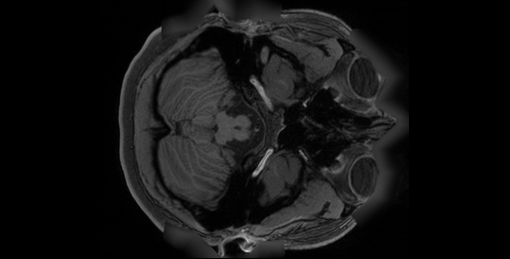

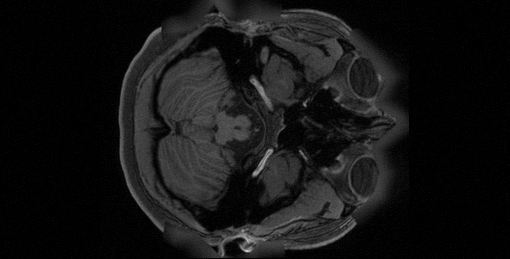

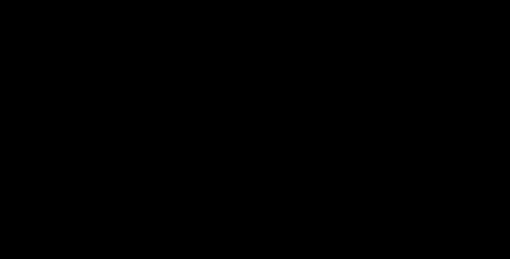

noisy img rrmse: 0.18
reconstructed img rrmse: 1.78


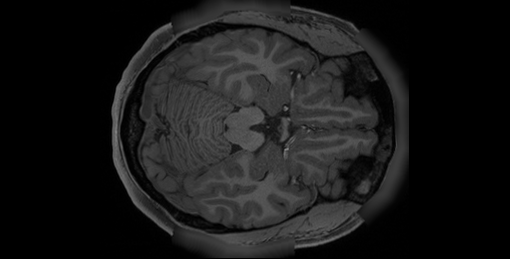

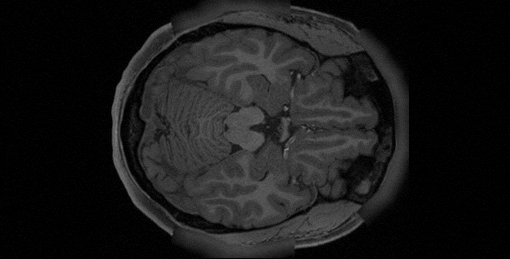

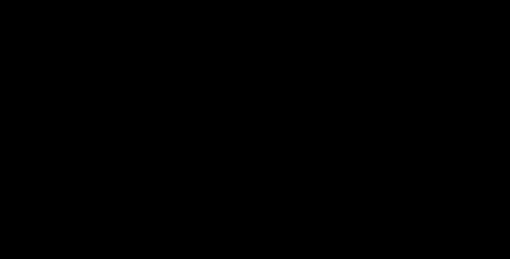

noisy img rrmse: 0.20
reconstructed img rrmse: 2.28


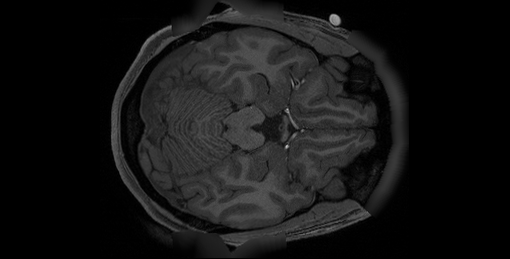

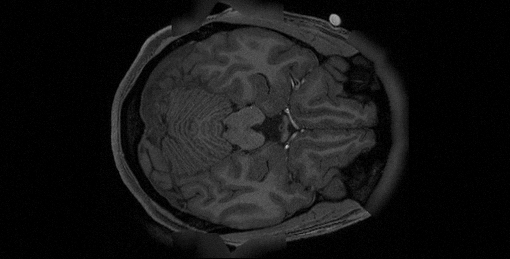

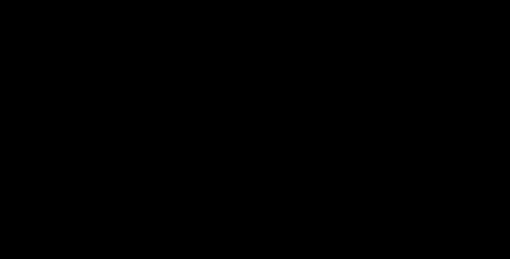

noisy img rrmse: 0.21
reconstructed img rrmse: 2.12


In [22]:
from IPython.display import display

def plot_spec(spec):
    spec = abs(spec)
    spec = np.log10(spec)
    spec -= spec.min()
    spec *= 255/spec.max()
    display(Image.fromarray(spec).convert('L'))

def plot_img(img):
    img = Image.fromarray((img+0.5)*255)
    img = img.convert('L')
    display(img)

for id in [2,10,30]:
    plot_img(test_img[id])
    plot_img(test_X[id])
    plot_img(test_output[id])
    rrmse_inp = rrmse(test_img[id], test_X[id])
    print("noisy img rrmse: %.2f" % rrmse_inp)
    rrmse_inp = rrmse(test_img[id], test_output[id])
    print("reconstructed img rrmse: %.2f" % rrmse_inp)